In [2]:
import os
import time
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

from imblearn.over_sampling import SMOTE
from collections import Counter

import librosa
from pydub import AudioSegment
from pydub.silence import split_on_silence


from sklearn.model_selection import GroupShuffleSplit, KFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler



import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, LSTM
from keras.models import Model, Sequential
from keras.optimizers import SGD

import opensmile

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle

import seaborn as sns
import torch

In [122]:
#print("Current directory:", os.getcwd())
#print("Directory contents:", os.listdir('.'))

from src.models import lstm, RandomForest
from src.data_loader import DataLoader

In [5]:
def one_hot_encoder(y):
    enc = OneHotEncoder(sparse_output=False)  
    return enc.fit_transform(y.reshape(-1, 1)) 


def normalization(X):
    scaler = StandardScaler()
    X_shape = X.shape
    if len(X_shape) == 3:
        X_reshaped = X.reshape(-1, X.shape[-1])
        X_scaled = scaler.fit_transform(X_reshaped)
        X = X_scaled.reshape(X_shape[0], X_shape[1], X_shape[2])
        return X
    else:
        print("Debería ser dimenison 3")

def SMOTE_(X, y):
    x_shape = X.shape
    if len(x_shape) ==3:
        X = X.reshape((x_shape[0], -1))
    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)
    if len(x_shape) == 3:
        X = X.reshape((-1, x_shape[1], x_shape[2]))
    return X, y


In [2]:
"""
speech_unprocessed_path = r'data/Audio_Speech_Actors_01-24/*/*.wav'
song_unprocessed_path = r'data/Audio_Song_Actors_01-24/*/*.wav'

speech_dataset_path = "data/speech_dataset.npy"
song_dataset_path = "data/song_dataset.npy"
"""

In [ ]:
"""
class Dataloader():
    def __init__(self):
        pass
        # super(AudioDataloader, self).__init__(*args, **kwargs)
        # self.collate_fn = collate_fn

    def segment_audio(self, audio, num_parts):
        segment_length = len(audio) // num_parts
        segments = [audio[i * segment_length:(i + 1) * segment_length] for i in range(num_parts)]
        
        # Si el audio no se divide exactamente en partes iguales, añade el residuo al último segmento
        if len(audio) % num_parts != 0:
            segments[-1] = np.concatenate([segments[-1], audio[num_parts * segment_length:]])
        
        return segments


    def process_dataset(self, data_path, save_path, n_segments = 1):
        files = glob(data_path)

        smile = opensmile.Smile(
            feature_set=opensmile.FeatureSet.eGeMAPSv02,
            feature_level=opensmile.FeatureLevel.Functionals,
        )
        extracted_features = smile.process_files(files)

        x_ = extracted_features.values
        y_ = np.array([int(os.path.basename(path).split('-')[2]) for path in files])
        y_reshaped = y_[:, np.newaxis] 
        dataset = np.concatenate((x_, y_reshaped), axis=1)
        
        actors = np.array([int(os.path.dirname(path)[-2:]) for path in files])
        np.save(save_path, dataset)
        actors_save_path = f"data/{os.path.basename(save_path).split('_')[0]}_actors.npy"
        np.save(actors_save_path, actors)

        #np.savez(save_path, array1=dataset, array2=actors)
        return np.load(save_path), np.load(actors_save_path)
    
    def get_dataset(self, dataset_path_list):
        dataset = np.load(dataset_path_list[0])
        actors_path_list = f"{os.path.dirname(dataset_path_list[0])}/{os.path.basename(dataset_path_list[0]).split('_')[0]}_actors{os.path.splitext(dataset_path_list[0])[1]}"
        actors = np.load(actors_path_list)
        for i in range(1, len(dataset_path_list)):
            dataset = np.concatenate((dataset, np.load(dataset_path_list[i])))
            actors_path_list = f"{os.path.dirname(dataset_path_list[i])}/{os.path.basename(dataset_path_list[i]).split('_')[0]}_actors{os.path.splitext(dataset_path_list[i])[1]}"
            actors = np.concatenate((actors, np.load(actors_path_list)))
        x = dataset[:, :-1]
        y = dataset[:,-1]

        
        return x, y, actors

    def split_dataset(self, x, y, actors = [], n_splits =1):
        if len(actors) >0:
            gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
            train_idx, test_idx = next(gss.split(x, y, actors))
            X_train, X_test = x[train_idx], x[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            actors_train = actors[train_idx]
            actors_test = actors[test_idx]
       
        else:
            X_train, X_test, y_train, y_test = train_test_split(x, y, shuffle=42)
            actors_train = None
            actors_test = None
        return X_train, X_test, y_train, y_test, actors_train, actors_test

DL = Dataloader()
"""

In [ ]:
"""def calculate_energy(audio, frame_size, hop_length):
    energy = np.array([np.sum(np.abs(audio[i:i+frame_size]**2)) for i in range(0, len(audio), hop_length)])
    return energy

def trim_silence(audio, frame_size=1024, hop_length=512, energy_threshold=0.01):
    energy = calculate_energy(audio, frame_size, hop_length)
    frames = np.nonzero(energy > energy_threshold)[0]
    
    if len(frames) > 0:
        start = max(0, frames[0] * hop_length)
        end = min(len(audio), frames[-1] * hop_length + frame_size)
        return audio[start:end]
    else:
        return audio  # No recortar si no se encuentran frames con energía suficiente
"""


In [ ]:
## tendria qeu hacer el split de train y test antes para que siempre sea el mismo test
"""
class AudioProcessor:
    def segment_audio(self, audio, num_parts, frame_size=1024, hop_length=512, energy_threshold=0.01):
        # Recortar los silencios basados en la energía
        #print("")
        #print("audio largo", len(audio))
        trimmed_audio = trim_silence(audio, frame_size, hop_length, energy_threshold)
        #print("trimmed largo", len(trimmed_audio))
        print("Largo trimmed", len(trimmed_audio))
        if len(trimmed_audio) < 10000:
            plt.plot(audio)
            plt.show()
            print("Largo trimmed", len(trimmed_audio))
            plt.plot(trimmed_audio)
            plt.show()

        # Segmentar el audio recortado
        segment_length = len(trimmed_audio) // num_parts
        segments = []

        for i in range(num_parts):
            start = i * segment_length
            end = (i + 1) * segment_length
            segment = trimmed_audio[start:end]
            
            # Si el segmento es demasiado corto, rellenar con ceros
            if len(segment) < segment_length:
                segment = np.pad(segment, (0, segment_length - len(segment)), 'constant')
            
            segments.append(segment)
        
        return segments



    def segment_audio2(self, audio, num_parts, top_db=30):
        # Recortar los silencios
        #print("")
        #print("audio largo", len(audio))
        trimmed_audio, _ = librosa.effects.trim(audio, top_db=top_db)

        #print("trimmed largo", len(trimmed_audio))
        if len(trimmed_audio) == len(audio):
            plt.plot(audio)
            plt.show()
            print(audio)
            plt.plot(trimmed_audio)
            plt.show()
        segment_length = len(trimmed_audio) // num_parts
        segments = []

        for i in range(num_parts):
            start = i * segment_length
            end = (i + 1) * segment_length
            segment = trimmed_audio[start:end]
            #print("start", start)
            #print("end", end)
            
            # Si el segmento es demasiado corto, rellenar con ceros
            if len(segment) < segment_length:
                segment = np.pad(segment, (0, segment_length - len(segment)), 'constant')
            
            segments.append(segment)
        
        return segments


    def process_dataset(self, data_path, save_path, n_segments=1):

        files = glob(data_path)
        #files = [data_path]

        smile = opensmile.Smile(
            feature_set=opensmile.FeatureSet.eGeMAPSv02,
            feature_level=opensmile.FeatureLevel.Functionals,
        )

        features_list = []
        labels_list = []

        for file in files:
            # Cargar y segmentar el audio
            audio, sr = sf.read(file)
            print(file)
            segments = self.segment_audio2(audio, n_segments) ## CAMBIO sacar el 2

            for segment in segments:
                #print(len(segment))
                segment_file = 'temp_segment.wav'
                sf.write(segment_file, segment, sr)
                features = smile.process_file(segment_file)
                features_list.append(features.values.flatten())
                labels_list.append(int(os.path.basename(file).split('-')[2]))

        x_ = np.array(features_list)
        y_ = np.array(labels_list)
        
        y_reshaped = y_[:, np.newaxis]
        dataset = np.concatenate((x_, y_reshaped), axis=1)

        actors = np.array([int(os.path.dirname(path)[-2:]) for path in files])
        np.save(save_path, dataset)
        print('guardo el dataset en,', save_path)
        actors_save_path = define_actors_path(save_path)
        np.save(actors_save_path, actors)

        return np.load(save_path)

    def get_dataset(self, dataset_path_list):
        n_segments = int(os.path.basename(dataset_path_list[0])[0])
        dataset = np.load(dataset_path_list[0])
        actors_path = define_actors_path(dataset_path_list[0])
        print(actors_path)
        actors = np.load(actors_path)
        
        for i in range(1, len(dataset_path_list)):
            dataset = np.concatenate((dataset, np.load(dataset_path_list[i])))
            actors_path = actors_path = define_actors_path(dataset_path_list[i])
            actors = np.concatenate((actors, np.load(actors_path)))

        # Extraer características (x) y etiquetas (y)
        x = dataset[:, :-1]
        y = dataset[:, -1]
        # Realizar reshape de x
        num_samples = x.shape[0] // n_segments
        num_features = x.shape[1]
        x = x.reshape(num_samples, n_segments, num_features)
        
        # Realizar reshape de y
        y = y.reshape(num_samples, n_segments).mean(axis=1).astype(int)
        
        # Ajustar actores al nuevo número de muestras
        #actors_reshaped = actors.reshape(num_samples, n_segments).mean(axis=1).astype(int)

        print(x.shape)
        print(y.shape)
        print(actors.shape)
        return x, y, actors

    def split_dataset(self, x, y, test_size = 0.2, actors=[]):
        if len(actors) > 0:
            gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
            train_idx, test_idx = next(gss.split(x, y, actors))
            X_train, X_test = x[train_idx], x[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            actors_train = actors[train_idx]
            print("ACTORES", len(np.unique(actors_train)))
            actors_test = actors[test_idx]

            train_shuffle_idx = np.random.permutation(len(X_train))
            test_shuffle_idx = np.random.permutation(len(X_test))
            
            X_train, y_train, actors_train = X_train[train_shuffle_idx], y_train[train_shuffle_idx], actors_train[train_shuffle_idx]
            X_test, y_test, actors_test = X_test[test_shuffle_idx], y_test[test_shuffle_idx], actors_test[test_shuffle_idx]

        else:
            X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
            actors_train = None
            actors_test = None

        return X_train, X_test, y_train, y_test, actors_train, actors_test
    
def define_actors_path(dataset_path):
    file_name = os.path.basename(dataset_path).split('_')
    file_name[-1] = file_name[-1].split('.')[0]
    actors_save_path = f"data/{file_name[0]}_{file_name[1]}_actors_{file_name[3]}.npy"
    return actors_save_path


AP = AudioProcessor()
"""


In [6]:
DL = DataLoader()



se inicializo


In [74]:
speech1_dataset_dev = "data/1part_Speech_dataset_dev.npy"
speech2_dataset_dev = "data/2part_Speech_dataset_dev.npy"
speech4_dataset_dev = "data/4part_Speech_dataset_dev.npy"
speech8_dataset_dev = "data/8part_Speech_dataset_dev.npy"
speech16_dataset_dev = "data/16part_Speech_dataset_dev.npy"
song1_dataset_dev = "data/1part_Song_dataset_dev.npy"
song2_dataset_dev = "data/2part_Song_dataset_dev.npy"
song4_dataset_dev = "data/4part_Song_dataset_dev.npy"
song8_dataset_dev = "data/8part_Song_dataset_dev.npy"
song16_dataset_dev = "data/16part_Song_dataset_dev.npy"

speech1_dataset_test = "data/1part_Speech_dataset_test.npy"
speech2_dataset_test = "data/2part_Speech_dataset_test.npy"
speech4_dataset_test = "data/4part_Speech_dataset_test.npy"
speech8_dataset_test = "data/8part_Speech_dataset_test.npy"
speech16_dataset_test = "data/16part_Speech_dataset_test.npy"
song1_dataset_test = "data/1part_Song_dataset_test.npy"
song2_dataset_test = "data/2part_Song_dataset_test.npy"
song4_dataset_test = "data/4part_Song_dataset_test.npy"
song8_dataset_test = "data/8part_Song_dataset_test.npy"
song16_dataset_test = "data/16part_Song_dataset_test.npy"

path_speech_dev = r"data\Audio_Speech_Actors_01-24\*\*"
path_song_dev = r"data\Audio_Song_Actors_01-24\*\*"
path_speech_test = r"data/data_test/speech/*/*"
path_song_test = r"data/data_test/song/*/*"


"data\Audio_Speech_Actors_01-24\Actor_09\03-01-04-01-01-01-09.wav"
r"data\Audio_Speech_Actors_01-24\Actor_09\03-01-02-01-02-01-09(1).wav"

'data\\Audio_Speech_Actors_01-24\\Actor_09\\03-01-02-01-02-01-09(1).wav'

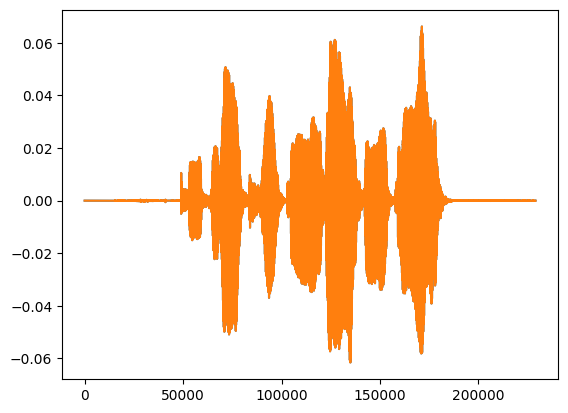

[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
guardo el dataset en, data/16part_Song_dataset_dev.npy
guardo los actores en, data/16part_Song_actors_dev.npy


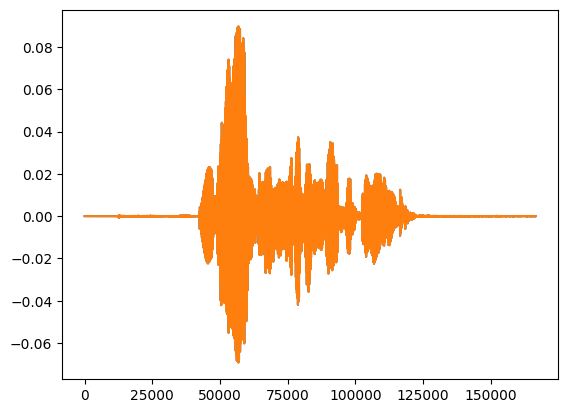

[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


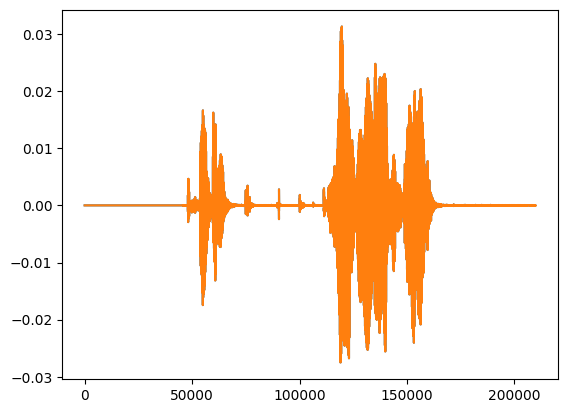

[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
guardo el dataset en, data/16part_Speech_dataset_dev.npy
guardo los actores en, data/16part_Speech_actors_dev.npy
guardo el dataset en, data/16part_Song_dataset_test.npy
guardo los actores en, data/16part_Song_actors_test.npy


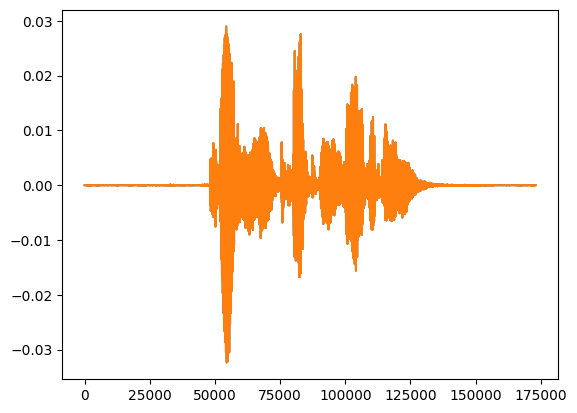

[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


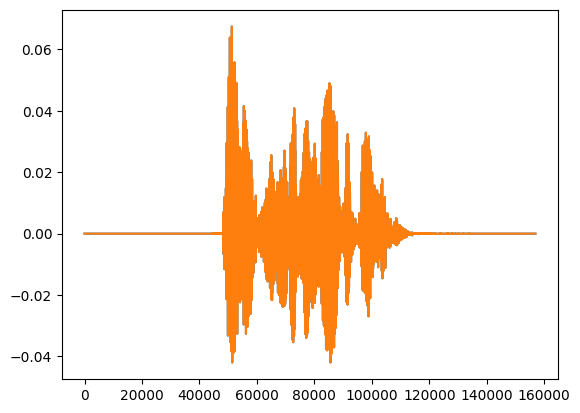

[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


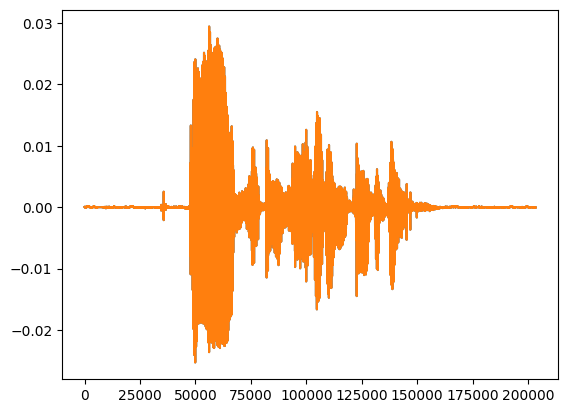

[[ 3.05175781e-05  3.05175781e-05]
 [ 0.00000000e+00  0.00000000e+00]
 [ 3.05175781e-05  3.05175781e-05]
 ...
 [-6.10351562e-05 -6.10351562e-05]
 [-6.10351562e-05 -6.10351562e-05]
 [-6.10351562e-05 -6.10351562e-05]]
guardo el dataset en, data/16part_Speech_dataset_test.npy
guardo los actores en, data/16part_Speech_actors_test.npy


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -6.72881546e+01,  1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -6.76102982e+01,  1.00000000e+00],
       [ 2.89841557e+01,  0.00000000e+00,  2.89841557e+01, ...,
         0.00000000e+00, -3.90751877e+01,  1.00000000e+00],
       ...,
       [ 3.53234215e+01,  2.56310552e-02,  3.44825096e+01, ...,
         0.00000000e+00, -3.41026306e+01,  8.00000000e+00],
       [ 4.20704346e+01,  0.00000000e+00,  4.20704346e+01, ...,
         0.00000000e+00, -3.99658470e+01,  8.00000000e+00],
       [ 1.67677975e+01,  7.37421960e-02,  1.57721043e+01, ...,
         0.00000000e+00, -4.31665535e+01,  8.00000000e+00]])

In [72]:
DL.process_dataset(path_song_dev, song16_dataset_dev, 16)
DL.process_dataset(path_speech_dev, speech16_dataset_dev, 16)
DL.process_dataset(path_song_test, song16_dataset_test, 16)
DL.process_dataset(path_speech_test, speech16_dataset_test, 16)



data/1part_Song_actors_dev.npy
X shape (792, 1, 88)
y shape (792,)
actors shape (792,)
data/1part_Song_actors_test.npy
X shape (220, 1, 88)
y shape (220,)
actors shape (220,)
Distribución de clases antes de SMOTE train: Counter({5: 112, 3: 112, 2: 112, 4: 112, 6: 112, 1: 56})
Distribución de clases antes de SMOTE valid: Counter({6: 32, 2: 32, 3: 32, 5: 32, 4: 32, 1: 16})
Distribución de clases antes de SMOTE test: Counter({2: 40, 3: 40, 4: 40, 5: 40, 6: 40, 1: 20})
Distribución de clases despues de SMOTE train: Counter({1: 112, 5: 112, 3: 112, 2: 112, 4: 112, 6: 112})
Distribución de clases despues de SMOTE train: Counter({6: 32, 2: 32, 3: 32, 5: 32, 4: 32, 1: 16})
Distribución de clases despues de SMOTE train: Counter({2: 40, 3: 40, 4: 40, 5: 40, 6: 40, 1: 20})


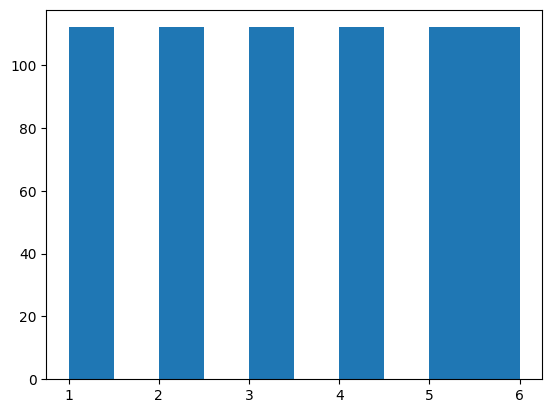

s
(672, 1, 88)
(176, 1, 88)


In [88]:
X_dev, y_dev, actors_dev = DL.get_dataset([song1_dataset_dev])
X_train, X_valid, y_train, y_valid, actors_train, actors_valid = DL.split_dataset(X_dev, y_dev, test_size=0.2, actors=actors_dev)
X_test, y_test, actors_test = DL.get_dataset([song1_dataset_test])

print('Distribución de clases antes de SMOTE train:', Counter(y_train))
print('Distribución de clases antes de SMOTE valid:', Counter(y_valid))
print('Distribución de clases antes de SMOTE test:', Counter(y_test))


X_train, y_train = SMOTE_(X_train, y_train)
#X_valid, y_valid = SMOTE_(X_valid, y_valid)
#X_test, y_test = SMOTE_(X_test, y_test)


print('Distribución de clases despues de SMOTE train:', Counter(y_train))
print('Distribución de clases despues de SMOTE train:', Counter(y_valid))
print('Distribución de clases despues de SMOTE train:', Counter(y_test))



plt.hist(y_train)
plt.show()


print("s")
print(X_train.shape)
print(X_valid.shape)

X_train = normalization(X_train)
X_valid = normalization(X_valid)
X_test = normalization(X_test)

y_train_ohe  = one_hot_encoder(y_train)
y_valid_ohe = one_hot_encoder(y_valid)
y_test_ohe = one_hot_encoder(y_test)
y_dev_ohe = one_hot_encoder(y_dev)



In [62]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

class rnnLSTM():
    def __init__(self, X_train, y_train, lr = 0.001, patience = 3, dropout_rate = 0.5, momentum = 0.9):
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        self.model = Sequential()
        self.model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        self.model.add(Dropout(dropout_rate))
        self.model.add(LSTM(128, return_sequences=False))
        self.model.add(Dropout(dropout_rate))
        self.model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        self.model.add(Dropout(dropout_rate))
        self.model.add(Dense(y_train.shape[1], activation='softmax'))
        self.model.compile(optimizer=SGD(learning_rate=lr, momentum=momentum), loss='categorical_crossentropy', metrics=['accuracy'])

    def train(self, X_train, y_train, X_valid, y_valid, epochs=10, batch_size=32, random_seed=42):
        print("cambio")
        tf.random.set_seed(random_seed)
        self.history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[self.early_stopping])

    def evaluate(self, X_test, y_test):
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test)
        return test_loss, test_accuracy
    
    def plot_learning_curves(self):
        history_dict = self.history.history
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']
        accuracy = history_dict['accuracy']
        val_accuracy = history_dict['val_accuracy']
        
        epochs = range(1, len(loss) + 1)
        
        plt.figure(figsize=(14, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
        plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.show()


class rnnLSTM2():
    def __init__(self, X_train, y_train, lr=0.0001, patience=10, dropout_rate=0.6, lstm_units=128, optimizer_type='Adam'):
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience//2, min_lr=1e-6)
        
        self.model = Sequential()
        self.model.add(LSTM(lstm_units, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(X_train.shape[1], X_train.shape[2])))
        self.model.add(Dropout(dropout_rate))
        self.model.add(LSTM(lstm_units, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        self.model.add(Dropout(dropout_rate))
        self.model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        self.model.add(Dropout(dropout_rate))
        self.model.add(Dense(y_train.shape[1], activation='softmax'))
        
        if optimizer_type == 'Adam':
            optimizer = Adam(learning_rate=lr)
        else:
            optimizer = SGD(learning_rate=lr, momentum=0.9)
        
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    def train(self, X_train, y_train, X_valid, y_valid, epochs=50, batch_size=32, random_seed=42):
        tf.random.set_seed(random_seed)
        self.history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[self.early_stopping, self.reduce_lr])

    def evaluate(self, X_test, y_test):
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test)
        return test_loss, test_accuracy

    def plot_learning_curves(self):
        history_dict = self.history.history
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']
        accuracy = history_dict['accuracy']
        val_accuracy = history_dict['val_accuracy']
        
        epochs = range(1, len(loss) + 1)
        
        plt.figure(figsize=(14, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
        plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.show()

## LSTM con keras

In [59]:

def cross_validate_rnn(X, y, groups, n_splits=5, epochs=100, batch_size=32, learning_rate = 0.001, dropout = 0.5, momentum =0.9):
    valid_loss = []
    gkf = GroupKFold(n_splits=n_splits)
    fold_no = 1
    print(y.shape)
    for train_index, val_index in gkf.split(X, y, groups):
        print(f'Training fold {fold_no} ...')
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        X_train, y_train = shuffle(X_train, y_train, random_state=42)
        X_val, y_val = shuffle(X_val, y_val, random_state=42)

        print(y_train)
        print(X_train.shape)
        print(y_train.shape)
        print(X_val.shape)
        print(y_val.shape)
        model = lstm.rnnLSTM(X_train, y_train, lr= learning_rate, dropout_rate=dropout, momentum=momentum)
        model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)

        val_loss, val_accuracy = model.evaluate(X_val, y_val)
        print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        valid_loss.append(val_loss)
        fold_no += 1
    return np.mean(valid_loss)



In [65]:
batches_size = [32, 64]
lrs = [0.001]
dropout = [0.2, 0.5]
momentum = [0.7, 0.9]

hyperparams = list(itertools.product(batches_size, lrs, dropout, momentum))
print(y_dev_ohe.shape)

valid_loss = []
for i in tqdm(range(len(hyperparams))):
    batch_s, lr, drop, moment = hyperparams[i]
    loss = cross_validate_rnn(X_dev, y_dev_ohe, actors_dev, batch_size=batch_s, learning_rate=lr, dropout=drop, momentum=moment)
    valid_loss.append(loss)


(1948, 8)


  0%|          | 0/8 [00:00<?, ?it/s]

(1948, 8)
Training fold 1 ...
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
(1570, 4, 88)
(1570, 8)
(378, 4, 88)
(378, 8)
cambio
Epoch 1/100
50/50 [==============================] - 4s 30ms/step - loss: 3.3312 - accuracy: 0.1580 - val_loss: 3.3254 - val_accuracy: 0.1561
Epoch 2/100
50/50 [==============================] - 1s 14ms/step - loss: 3.3223 - accuracy: 0.1561 - val_loss: 3.3109 - val_accuracy: 0.1905
Epoch 3/100
50/50 [==============================] - 1s 14ms/step - loss: 3.2966 - accuracy: 0.1624 - val_loss: 3.2948 - val_accuracy: 0.2063
Epoch 4/100
50/50 [==============================] - 1s 15ms/step - loss: 3.2864 - accuracy: 0.1554 - val_loss: 3.2843 - val_accuracy: 0.1852
Epoch 5/100
50/50 [==============================] - 1s 15ms/step - loss: 3.2728 - accuracy: 0.1745 - val_loss: 3.2730 - val_accuracy: 0.1825
Epoch 6/100
50/50 [==============================] 

 12%|█▎        | 1/8 [05:13<36:36, 313.76s/it]

Fold 5 - Validation Loss: 2.6448, Validation Accuracy: 0.2476
(1948, 8)
Training fold 1 ...
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
(1570, 4, 88)
(1570, 8)
(378, 4, 88)
(378, 8)
cambio
Epoch 1/100
50/50 [==============================] - 4s 30ms/step - loss: 3.3401 - accuracy: 0.1554 - val_loss: 3.3033 - val_accuracy: 0.2143
Epoch 2/100
50/50 [==============================] - 1s 13ms/step - loss: 3.3016 - accuracy: 0.1561 - val_loss: 3.2791 - val_accuracy: 0.1508
Epoch 3/100
50/50 [==============================] - 1s 16ms/step - loss: 3.2659 - accuracy: 0.1643 - val_loss: 3.2528 - val_accuracy: 0.2011
Epoch 4/100
50/50 [==============================] - 1s 16ms/step - loss: 3.2451 - accuracy: 0.1726 - val_loss: 3.2293 - val_accuracy: 0.1905
Epoch 5/100
50/50 [==============================] - 1s 16ms/step - loss: 3.2142 - accuracy: 0.1682 - val_loss: 3.2062 - val_accura

 25%|██▌       | 2/8 [10:43<32:19, 323.19s/it]

Fold 5 - Validation Loss: 2.5415, Validation Accuracy: 0.2788
(1948, 8)
Training fold 1 ...
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
(1570, 4, 88)
(1570, 8)
(378, 4, 88)
(378, 8)
cambio
Epoch 1/100
50/50 [==============================] - 4s 29ms/step - loss: 3.4148 - accuracy: 0.1369 - val_loss: 3.3612 - val_accuracy: 0.1481
Epoch 2/100
50/50 [==============================] - 1s 16ms/step - loss: 3.3725 - accuracy: 0.1446 - val_loss: 3.3370 - val_accuracy: 0.1508
Epoch 3/100
50/50 [==============================] - 1s 16ms/step - loss: 3.3705 - accuracy: 0.1490 - val_loss: 3.3213 - val_accuracy: 0.1561
Epoch 4/100
50/50 [==============================] - 1s 16ms/step - loss: 3.3490 - accuracy: 0.1452 - val_loss: 3.3102 - val_accuracy: 0.1508
Epoch 5/100
50/50 [==============================] - 1s 16ms/step - loss: 3.3270 - accuracy: 0.1503 - val_loss: 3.2994 - val_accura

 38%|███▊      | 3/8 [17:49<30:51, 370.29s/it]

Fold 5 - Validation Loss: 2.6761, Validation Accuracy: 0.2284
(1948, 8)
Training fold 1 ...
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
(1570, 4, 88)
(1570, 8)
(378, 4, 88)
(378, 8)
cambio
Epoch 1/100
50/50 [==============================] - 8s 55ms/step - loss: 3.3759 - accuracy: 0.1446 - val_loss: 3.3255 - val_accuracy: 0.1455
Epoch 2/100
50/50 [==============================] - 1s 22ms/step - loss: 3.3203 - accuracy: 0.1459 - val_loss: 3.2875 - val_accuracy: 0.1693
Epoch 3/100
50/50 [==============================] - 1s 22ms/step - loss: 3.2925 - accuracy: 0.1599 - val_loss: 3.2596 - val_accuracy: 0.1561
Epoch 4/100
50/50 [==============================] - 1s 24ms/step - loss: 3.2563 - accuracy: 0.1541 - val_loss: 3.2327 - val_accuracy: 0.1534
Epoch 5/100
50/50 [==============================] - 1s 21ms/step - loss: 3.2377 - accuracy: 0.1376 - val_loss: 3.2071 - val_accura

 50%|█████     | 4/8 [33:55<40:21, 605.44s/it]

(1948, 8)
Training fold 1 ...
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
(1570, 4, 88)
(1570, 8)
(378, 4, 88)
(378, 8)
cambio
Epoch 1/100
25/25 [==============================] - 13s 159ms/step - loss: 3.3559 - accuracy: 0.1248 - val_loss: 3.3308 - val_accuracy: 0.1931
Epoch 2/100
25/25 [==============================] - 2s 69ms/step - loss: 3.3317 - accuracy: 0.1554 - val_loss: 3.3157 - val_accuracy: 0.1984
Epoch 3/100
25/25 [==============================] - 2s 61ms/step - loss: 3.3159 - accuracy: 0.1688 - val_loss: 3.3049 - val_accuracy: 0.2249
Epoch 4/100
25/25 [==============================] - 1s 59ms/step - loss: 3.3069 - accuracy: 0.1796 - val_loss: 3.2954 - val_accuracy: 0.2143
Epoch 5/100
25/25 [==============================] - 1s 59ms/step - loss: 3.2946 - accuracy: 0.1828 - val_loss: 3.2865 - val_accuracy: 0.2434
Epoch 6/100
25/25 [==============================

 62%|██████▎   | 5/8 [44:32<30:49, 616.59s/it]

Fold 5 - Validation Loss: 2.9813, Validation Accuracy: 0.2500
(1948, 8)
Training fold 1 ...
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
(1570, 4, 88)
(1570, 8)
(378, 4, 88)
(378, 8)
cambio
Epoch 1/100
25/25 [==============================] - 8s 91ms/step - loss: 3.3328 - accuracy: 0.1535 - val_loss: 3.3163 - val_accuracy: 0.1138
Epoch 2/100
25/25 [==============================] - 1s 30ms/step - loss: 3.3154 - accuracy: 0.1586 - val_loss: 3.2942 - val_accuracy: 0.1481
Epoch 3/100
25/25 [==============================] - 1s 39ms/step - loss: 3.2946 - accuracy: 0.1643 - val_loss: 3.2775 - val_accuracy: 0.1693
Epoch 4/100
25/25 [==============================] - 1s 40ms/step - loss: 3.2686 - accuracy: 0.1822 - val_loss: 3.2631 - val_accuracy: 0.2011
Epoch 5/100
25/25 [==============================] - 1s 37ms/step - loss: 3.2635 - accuracy: 0.1701 - val_loss: 3.2463 - val_accura

 75%|███████▌  | 6/8 [51:34<18:21, 550.52s/it]

Fold 5 - Validation Loss: 2.6055, Validation Accuracy: 0.2139
(1948, 8)
Training fold 1 ...
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
(1570, 4, 88)
(1570, 8)
(378, 4, 88)
(378, 8)
cambio
Epoch 1/100
25/25 [==============================] - 4s 51ms/step - loss: 3.4338 - accuracy: 0.1236 - val_loss: 3.3563 - val_accuracy: 0.1481
Epoch 2/100
25/25 [==============================] - 1s 22ms/step - loss: 3.3941 - accuracy: 0.1299 - val_loss: 3.3513 - val_accuracy: 0.1878
Epoch 3/100
25/25 [==============================] - 0s 20ms/step - loss: 3.3942 - accuracy: 0.1299 - val_loss: 3.3387 - val_accuracy: 0.1349
Epoch 4/100
25/25 [==============================] - 1s 20ms/step - loss: 3.3768 - accuracy: 0.1325 - val_loss: 3.3254 - val_accuracy: 0.1852
Epoch 5/100
25/25 [==============================] - 1s 20ms/step - loss: 3.3645 - accuracy: 0.1287 - val_loss: 3.3193 - val_accura

 88%|████████▊ | 7/8 [56:20<07:43, 463.90s/it]

Fold 5 - Validation Loss: 2.9370, Validation Accuracy: 0.2067
(1948, 8)
Training fold 1 ...
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
(1570, 4, 88)
(1570, 8)
(378, 4, 88)
(378, 8)
cambio
Epoch 1/100
25/25 [==============================] - 4s 54ms/step - loss: 3.3944 - accuracy: 0.1261 - val_loss: 3.3469 - val_accuracy: 0.1508
Epoch 2/100
25/25 [==============================] - 1s 22ms/step - loss: 3.3609 - accuracy: 0.1382 - val_loss: 3.3160 - val_accuracy: 0.1534
Epoch 3/100
25/25 [==============================] - 1s 23ms/step - loss: 3.3212 - accuracy: 0.1420 - val_loss: 3.2937 - val_accuracy: 0.2011
Epoch 4/100
25/25 [==============================] - 1s 22ms/step - loss: 3.3040 - accuracy: 0.1490 - val_loss: 3.2791 - val_accuracy: 0.1693
Epoch 5/100
25/25 [==============================] - 1s 23ms/step - loss: 3.2852 - accuracy: 0.1567 - val_loss: 3.2654 - val_accura

100%|██████████| 8/8 [1:01:42<00:00, 462.80s/it]

Fold 5 - Validation Loss: 2.5192, Validation Accuracy: 0.1635


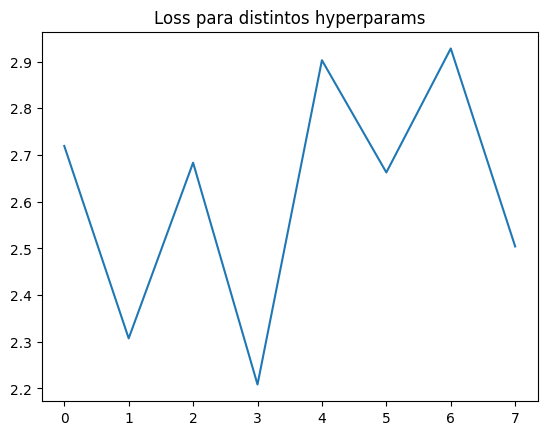

opt hyperparams:  (32, 0.001, 0.5, 0.9)
min val loss: 2.2084054946899414


In [66]:
plt.plot(range(len(valid_loss)), valid_loss)
plt.title("Loss para distintos hyperparams")
plt.show()

print("opt hyperparams: ", hyperparams[np.argmin(valid_loss)])
print("min val loss:", np.min(valid_loss))

train
cambio
Epoch 1/500
21/21 [==============================] - 4s 47ms/step - loss: 3.0767 - accuracy: 0.1473 - val_loss: 3.0749 - val_accuracy: 0.1136
Epoch 2/500
21/21 [==============================] - 0s 8ms/step - loss: 3.0666 - accuracy: 0.1920 - val_loss: 3.0636 - val_accuracy: 0.1420
Epoch 3/500
21/21 [==============================] - 0s 8ms/step - loss: 3.0577 - accuracy: 0.1518 - val_loss: 3.0521 - val_accuracy: 0.1250
Epoch 4/500
21/21 [==============================] - 0s 8ms/step - loss: 3.0461 - accuracy: 0.1920 - val_loss: 3.0406 - val_accuracy: 0.1193
Epoch 5/500
21/21 [==============================] - 0s 8ms/step - loss: 3.0339 - accuracy: 0.1860 - val_loss: 3.0293 - val_accuracy: 0.1136
Epoch 6/500
21/21 [==============================] - 0s 8ms/step - loss: 3.0225 - accuracy: 0.1964 - val_loss: 3.0178 - val_accuracy: 0.1364
Epoch 7/500
21/21 [==============================] - 0s 8ms/step - loss: 3.0101 - accuracy: 0.2054 - val_loss: 3.0069 - val_accuracy: 0.1534

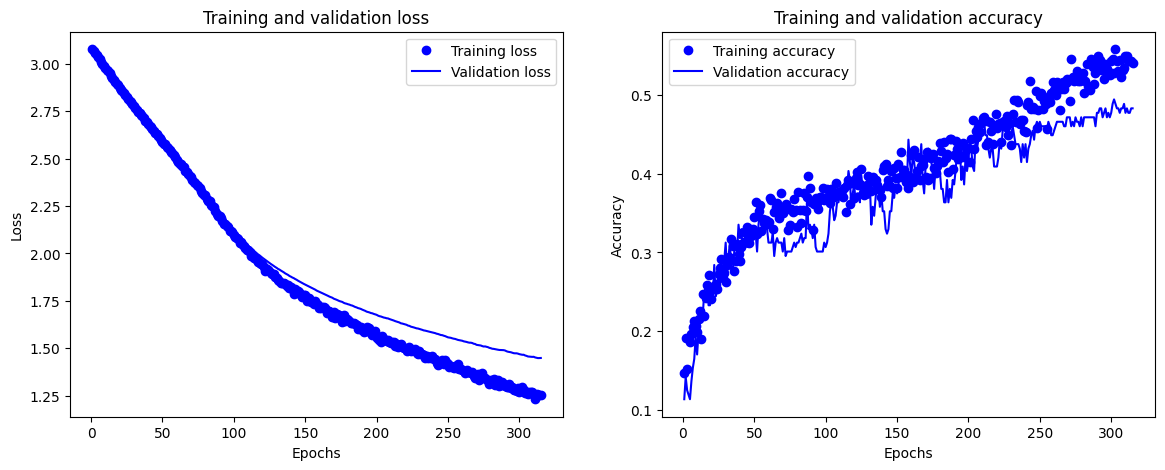

In [90]:
print("train")


#y_train_ohe  = one_hot_encoder(y_train)
#y_valid_ohe = one_hot_encoder(y_valid)
#y_test_ohe = one_hot_encoder(y_test)

#R = lstm.rnnLSTM(X_train, y_train_ohe, lr=0.001, dropout_rate=0.2, patience=2)
R = rnnLSTM(X_train, y_train_ohe, lr=0.001, dropout_rate=0.5, patience=2)
R.train(X_train, y_train_ohe, X_valid, y_valid_ohe, epochs=500, batch_size=32)
R.plot_learning_curves()

In [92]:
print("test")
test_loss, test_accuracy = R.evaluate(X_test, y_test_ohe)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

test
7/7 [==============================] - 0s 4ms/step - loss: 1.3741 - accuracy: 0.4500
Test Loss: 1.3740949630737305
Test Accuracy: 0.44999998807907104


## LSTM con pythorch

In [10]:
"""input_size = 3       # Número de características de entrada
hidden_size = 64     # Número de características en el estado oculto
num_classes = 8      # Número de clases de salida
num_layers = 1       # Número de capas de la LSTM
learning_rate = 0.001
batch_size = 32
num_epochs = 50

X_train_batch, y_train_batch = DL.create_batches(X_train, y_train, batch_size)
lstm_ = LSTM2.LSTMClassifier(input_size, hidden_size, num_classes, num_layers)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_.parameters(), lr=learning_rate)
lstm_.train_model(X_train_batch, y_train_batch, criterion, optimizer, num_epochs=20)
"""

'input_size = 3       # Número de características de entrada\nhidden_size = 64     # Número de características en el estado oculto\nnum_classes = 8      # Número de clases de salida\nnum_layers = 1       # Número de capas de la LSTM\nlearning_rate = 0.001\nbatch_size = 32\nnum_epochs = 50\n\nX_train_batch, y_train_batch = DL.create_batches(X_train, y_train, batch_size)\nlstm_ = LSTM2.LSTMClassifier(input_size, hidden_size, num_classes, num_layers)\n\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(lstm_.parameters(), lr=learning_rate)\nlstm_.train_model(X_train_batch, y_train_batch, criterion, optimizer, num_epochs=20)\n'

In [ ]:
"""x, y, actors = AP.get_dataset([speech8_dataset])
X_train, X_test, y_train, y_test, actors_train, actors_test = AP.split_dataset(x, y, test_size=0.2, actors=actors)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(actors_train.shape)
print(actors_test.shape)

X_train, X_valid, y_train, y_valid, actors_train, actors_valid = AP.split_dataset(X_train, y_train, test_size=0.2, actors=actors_train)
print("train:", X_train.shape)
print("valid:", X_valid.shape)

plt.hist(y_train)
plt.show()

y_train = one_hot_encoder(y_train)
y_valid = one_hot_encoder(y_valid)

scaler = StandardScaler()
shape_train = X_train.shape
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_train = X_train_scaled.reshape(shape_train[0], shape_train[1], shape_train[2])

shape_valid = X_valid.shape
X_val_reshaped = X_valid.reshape(-1, X_valid.shape[-1])
X_val_scaled = scaler.transform(X_val_reshaped)
X_val = X_val_scaled.reshape(shape_valid[0], shape_valid[1], shape_valid[2])


print(X_train.shape)


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_valid, y_valid))"""

In [ ]:
"""y_test = one_hot_encoder(y_test)

shape = X_test.shape
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler.transform(X_test_reshaped)
X_test = X_test_scaled.reshape(shape[0], shape[1], shape[2])

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
"""

In [ ]:
y_pred = model.predict(X_test)

# Convertir las predicciones de one-hot encoding a etiquetas
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print(y_pred_labels)
print(y_test_labels)

In [ ]:
#NO CORRER, USAR Dataloader.get_dataset() y Dataloader.split_dataset()
DL.process_dataset(speech_unprocessed_path, speech_dataset_path)
DL.process_dataset(song_unprocessed_path, song_dataset_path)

In [ ]:
# A partir de aca el TEST no se toca mas.
# Hay que hacer otra division del dev set para formar el train set y valid set.

x_speech, y_speech, actors_speech = DL.get_dataset([speech_dataset_path])
x_song, y_song, actors_song = DL.get_dataset([song_dataset_path])
x_both, y_both, actors_both = DL.get_dataset([speech_dataset_path, song_dataset_path])

# Estos son los datasets DIVIDIDOS POR ACTORES para el dev set y test set.
X_speech_byactors_dev, X_speech_byactors_test, y_speech_byactors_dev, y_speech_byactors_test, actors_speech_dev, actors_speech_test = DL.split_dataset(x_speech, y_speech, actors_speech)
X_song_byactors_dev, X_song_byactors_test, y_song_byactors_dev, y_song_byactors_test, actors_song_dev, actors_song_test = DL.split_dataset(x_song, y_song, actors_song)
X_both_byactors_dev, X_both_byactors_test, y_both_byactors_dev, y_both_byactors_test, actors_both_dev, actors_both_test = DL.split_dataset(x_both, y_both, actors_both)

# Estos son los datasets NO divididos por actores para el dev set y test set.
X_speech_dev, X_speech_test, y_speech_dev, y_speech_test, _ , _ = DL.split_dataset(x_speech, y_speech)
X_song_dev, X_song_test, y_song_dev, y_song_test, _ , _ = DL.split_dataset(x_song, y_song)
X_both_dev, X_both_test, y_both_dev, y_both_test, _ , _ = DL.split_dataset(x_both, y_both)


In [ ]:
# DIVISION ENTRE TRAIN SET Y VALIDATION SET

X_speech_byactors_train, X_speech_byactors_valid, y_speech_byactors_train, y_speech_byactors_valid, actors_speech_train, actors_speech_valid = DL.split_dataset(X_speech_byactors_dev, y_speech_byactors_dev, actors_speech_dev)
X_song_byactors_train, X_song_byactors_valid, y_song_byactors_train, y_song_byactors_valid, actors_song_train, actors_song_valid = DL.split_dataset(X_song_byactors_dev, y_song_byactors_dev, actors_song_dev)
X_both_byactors_train, X_both_byactors_valid, y_both_byactors_train, y_both_byactors_valid, actors_both_train, actors_both_valid = DL.split_dataset(X_both_byactors_dev, y_both_byactors_dev, actors_both_dev)

X_speech_train, X_speech_valid, y_speech_train, y_speech_valid, _ , _ = DL.split_dataset(X_speech_dev, y_speech_dev)
X_song_train, X_song_valid, y_song_train, y_song_valid, _ , _ = DL.split_dataset(X_song_dev, y_song_dev)
X_both_train, X_both_valid, y_both_train, y_both_valid, _ , _ = DL.split_dataset(X_both_dev, y_both_dev)


### habria que hacer una funcion que devuelva especificamente el train, valid del dataset que queremos. Ahora lo hice asi para ya tenerlos todos creados y poder probarlos.


In [ ]:

x_train_norm = normalization(X_speech_byactors_train, np.mean(X_speech_byactors_train, axis=0), np.std(X_speech_byactors_train, axis=0))
x_valid_norm = normalization(X_speech_byactors_valid, np.mean(X_speech_byactors_train, axis=0), np.std(X_speech_byactors_train, axis=0))
print(x_train_norm.shape)
print(x_valid_norm.shape)

In [ ]:
classes_speech, classes_count_speech = np.unique(y_speech, return_counts=True)
classes_song, classes_count_song = np.unique(y_song, return_counts=True)

fig, axs = plt.subplots(1, 2, figsize=(8, 4)) 

axs[0].bar(classes_speech, classes_count_speech)
axs[0].set_title('Speech dataset')
axs[0].set_xlabel('Clase')
axs[0].set_ylabel('Cantidad de muestras')
axs[0].set_xticks(classes_speech) 

axs[1].bar(classes_song, classes_count_song)
axs[1].set_title('Song dataset')
axs[1].set_xlabel('Clase')
axs[1].set_ylabel('Cantidad de muestras')
axs[1].set_xticks(classes_song)

plt.tight_layout()
plt.show()

#NOTE: There is no strong intensity for the 'neutral' emotion.

In [ ]:
print(np.unique(y_speech))
print(np.unique(y_song))

# y_speech = y_speech.astype(int)
# y_song = y_song.astype(int)

In [ ]:
scaler_speech = StandardScaler()
x_speech_scaled = scaler_speech.fit_transform(x_speech)

scaler_song = StandardScaler()
x_song_scaled = scaler_song.fit_transform(x_song)

pca_speech = PCA(n_components=2)
pca_speech_result = pca_speech.fit_transform(x_speech_scaled)
pca_speech_df = pd.DataFrame(data=pca_speech_result, columns=['PCA1', 'PCA2'])
pca_speech_df['Label'] = y_speech

pca_song = PCA(n_components=2)
pca_song_result = pca_song.fit_transform(x_song_scaled)
pca_song_df = pd.DataFrame(data=pca_song_result, columns=['PCA1', 'PCA2'])
pca_song_df['Label'] = y_song

sns.scatterplot(x='PCA1', y='PCA2', hue='Label', data=pca_speech_df, palette='viridis')
plt.title('PCA of Speech Features')
plt.legend(title='Emotion')
plt.show()

sns.scatterplot(x='PCA1', y='PCA2', hue='Label', data=pca_song_df, palette='viridis')
plt.title('PCA of Song Features')
plt.legend(title='Emotion')
plt.show()

tsne_speech = TSNE(n_components=2, random_state=42)
tsne_speech_result = tsne_speech.fit_transform(x_speech_scaled)
tsne_speech_df = pd.DataFrame(data=tsne_speech_result, columns=['TSNE1', 'TSNE2'])
tsne_speech_df['Label'] = y_speech

tsne_song = TSNE(n_components=2, random_state=42)
tsne_song_result = tsne_song.fit_transform(x_song_scaled)
tsne_song_df = pd.DataFrame(data=tsne_song_result, columns=['TSNE1', 'TSNE2'])
tsne_song_df['Label'] = y_song

sns.scatterplot(x='TSNE1', y='TSNE2', hue='Label', data=tsne_speech_df, palette='viridis')
plt.title('t-SNE of Speech Features')
plt.legend(title='Emotion')
plt.show()

sns.scatterplot(x='TSNE1', y='TSNE2', hue='Label', data=tsne_song_df, palette='viridis')
plt.title('t-SNE of Song Features')
plt.legend(title='Emotion')
plt.show()


## Filename identifiers 

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

data/1part_Speech_actors_dev.npy
X shape (1948, 1, 88)
y shape (1948,)
actors shape (1948,)
data/1part_Speech_actors_test.npy
X shape (520, 1, 88)
y shape (520,)
actors shape (520,)


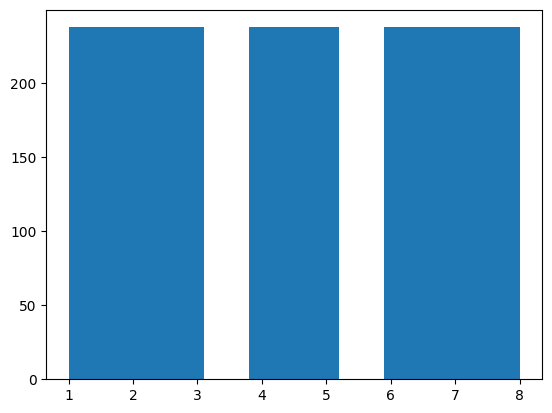

s
(1904, 1, 88)
(416, 1, 88)


In [94]:
X_dev, y_dev, actors_dev = DL.get_dataset([speech1_dataset_dev, song1_dataset_dev])
X_train, X_valid, y_train, y_valid, actors_train, actors_valid = DL.split_dataset(X_dev, y_dev, test_size=0.2, actors=actors_dev)
X_test, y_test, actors_test = DL.get_dataset([speech1_dataset_test, song1_dataset_test])


X_train, y_train = SMOTE_(X_train, y_train)
#X_valid, y_valid = SMOTE_(X_valid, y_valid)
#X_test, y_test = SMOTE_(X_test, y_test)


plt.hist(y_train)
plt.show()


print("s")
print(X_train.shape)
print(X_valid.shape)

# X_train = normalization(X_train)
# X_valid = normalization(X_valid)
# X_test = normalization(X_test)

y_train_ohe  = one_hot_encoder(y_train)
y_valid_ohe = one_hot_encoder(y_valid)
y_test_ohe = one_hot_encoder(y_test)
y_dev_ohe = one_hot_encoder(y_dev)



## Random Forest

In [123]:
"""class RandomForest_vl:
    def __init__(self, n_estimators=100, max_features='auto', max_depth=None,
                 min_samples_split=2, min_samples_leaf=1, bootstrap=True,
                 criterion='gini', random_state=42):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.bootstrap = bootstrap
        self.criterion = criterion
        self.random_state = random_state
        self.model = RandomForestClassifier(
            n_estimators=self.n_estimators,
            max_features=self.max_features,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            bootstrap=self.bootstrap,
            criterion=self.criterion,
            random_state=self.random_state
        )

    def fit(self, X_train, y_train, X_valid, y_valid):
        X_train_shape = X_train.shape
        X_valid_shape = X_valid.shape
        if len(X_train_shape) == 3:
            X_train = X_train.reshape(-1, X_train_shape[-1])
            X_valid = X_valid.reshape(-1, X_valid_shape[-1])
        self.model.fit(X_train, y_train)
        val_predictions = self.model.predict(X_valid)
        #X_train = X_train.reshape(X_train_shape[0], X_train_shape[1], X_train_shape[2])
        #X_test = X_test.reshape(X_test_shape[0], X_test_shape[1], X_test_shape[2])
        acc = accuracy_score(y_valid, val_predictions)
        print(f"Validation Accuracy: {acc}")
        return acc



    def predict(self, X):
        X_shape = X.shape
        if len(X_shape) == 3:
            X = X.reshape(-1, X_shape[-1])
        return self.model.predict(X)
"""

In [111]:


def cross_valid_RF(X, y, groups, num_trees, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap, criterion, n_splits=5):

    valid_acc = []
    gkf = GroupKFold(n_splits=n_splits)
    fold_no = 1
    print(y.shape)
    model = RandomForest.RandomForest(n_estimators=num_trees,
                             max_features=max_features,
                             max_depth=max_depth,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             bootstrap=bootstrap,
                             criterion=criterion)
    for train_index, val_index in gkf.split(X, y, groups):
        print(f'Training fold {fold_no} ...')
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        X_train, y_train = shuffle(X_train, y_train, random_state=42)
        X_val, y_val = shuffle(X_val, y_val, random_state=42)

        acc = model.fit(X_train, y_train, X_val, y_val)

        #val_loss, val_accuracy = model.evaluate(X_val, y_val)
        #print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        valid_acc.append(acc)
        fold_no += 1
    return np.mean(valid_acc)


In [ ]:
# NO CORRER (es el cross validation)


num_trees = [100, 200, 300, 400, 500]
max_features = ['sqrt', 'log2']
max_depth = [5, 10, 20, 30, 40, 50, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [2, 4, 10]
bootstrap = [True, False]
criterion = ['gini', 'entropy']

hyperparams = list(itertools.product(num_trees, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap, criterion))
hyperparams = np.array(hyperparams)
selected_indices = np.random.choice(len(hyperparams), 100, replace=False) # agarro 100 combinaciones random
selected_hyperparams = hyperparams[selected_indices]

valid_acc = []
for i in tqdm(range(len(selected_hyperparams))):
    print(selected_hyperparams[i])
    num_trees, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap, criterion = selected_hyperparams[i]
    acc = cross_valid_RF(X_dev, y_dev, actors_dev, num_trees, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap, criterion)
    valid_acc.append(acc)



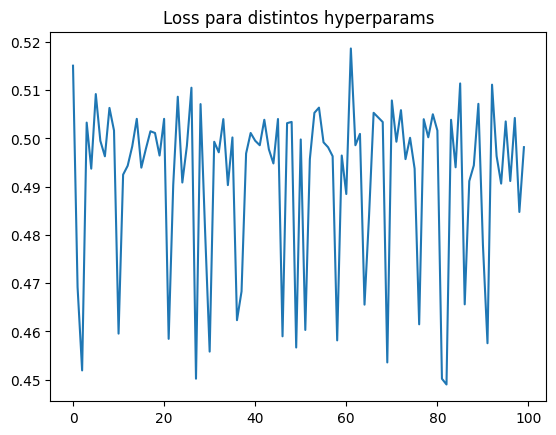

opt hyperparams:  [100 'sqrt' 10 10 2 True 'entropy']
max val acc: 0.5186477891430722


In [117]:
plt.plot(range(len(valid_acc)), valid_acc)
plt.title("Loss para distintos hyperparams")
plt.show()

RF_hyperparams_save_path = "configs/data/RF_hyperparameters.npy" 
np.save(RF_hyperparams_save_path, hyperparams[np.argmax(valid_acc)])
# se guarda los hiperparametros optimos calculados con CV. orden: num_trees, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap, criterion
print("opt hyperparams: ", hyperparams[np.argmax(valid_acc)])
print("max val acc:", np.max(valid_acc))


In [124]:
RF_hyperparams = np.load(RF_hyperparams_save_path, allow_pickle=True)


RF = RandomForest.RandomForest(n_estimators=RF_hyperparams[0],
                             max_features=RF_hyperparams[1],
                             max_depth=RF_hyperparams[2],
                             min_samples_split=RF_hyperparams[3],
                             min_samples_leaf=RF_hyperparams[4],
                             bootstrap=RF_hyperparams[5],
                             criterion=RF_hyperparams[6])

#X_shape_train = X_train.shape
#X_shape_test = X_test.shape

#if len(X_shape_train) ==3:
#    X_train = X_train.reshape(-1, X_shape_train[-1])
#    X_test = X_test.reshape(-1, X_shape_test[-1])
RF.fit(X_train, y_train, X_valid, y_valid)
#X_train = X_train.reshape(X_shape_train[0], X_shape_train[1], X_shape_train[2])
y_predict = RF.predict(X_test)
#X_test = X_test.reshape(X_shape_test[0], X_shape_test[1], X_shape_test[2])

acc = accuracy_score(y_test, y_predict)
print(f" trees --> test Accuracy {acc}")

conf_matrix = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_predict))


Validation Accuracy: 0.49278846153846156
 trees --> test Accuracy 0.5076923076923077
Confusion Matrix:
[[20  6  4  0  0  0  6  4]
 [ 8 52  6  7  0  2  5  0]
 [ 3  4 35  3 14  1  6 14]
 [ 6 20 10 21  1  9  8  5]
 [ 0  0  3  0 56  0 10 11]
 [ 4  3 17  2 17 25  9  3]
 [ 0  2  0  0  1  4 29  4]
 [ 2  0  0  1  4  4  3 26]]

Classification Report:
              precision    recall  f1-score   support

           1       0.47      0.50      0.48        40
           2       0.60      0.65      0.62        80
           3       0.47      0.44      0.45        80
           4       0.62      0.26      0.37        80
           5       0.60      0.70      0.65        80
           6       0.56      0.31      0.40        80
           7       0.38      0.72      0.50        40
           8       0.39      0.65      0.49        40

    accuracy                           0.51       520
   macro avg       0.51      0.53      0.49       520
weighted avg       0.53      0.51      0.50       520



In [ ]:
class MLPAutoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(MLPAutoencoder, self).__init__()
        #self.flatten = nn.Flatten()
        self.encoder = nn.Linear(88, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, 88)
        #self.unflatten = torch.nn.Unflatten(1, 88)

    def forward(self, x):
        #x = self.flatten(x)
        out = F.relu(self.encoder(x))
        out = torch.sigmoid(self.decoder(out))
        return out
    
    def get_embedding(self, x):
        #x = self.flatten(x)
        return F.relu(self.encoder(x))
d = torch.from_numpy(x_train)
print(d.shape)
print(nn.Flatten(d))
print(d[0].shape)
print(d)
print(d.dtype)

In [ ]:
model = MLPAutoencoder(33).double()
pred = model(d)


In [ ]:
LR = 0.1
device = "cpu"
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

n_epochs = 20
model.to(device)
t_losses, v_losses = [], []
x_train_tensor = torch.from_numpy(x_train_norm)
x_test_tensor = torch.from_numpy(x_test_norm)

for epoch in tqdm(range(1, n_epochs+1)):
    # Training
    train_loss = 0.0
    for (X, y) in zip(x_train_tensor, y_train):
        X = torch.squeeze(X).to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, X)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
            
    # Eval        
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for (X, y) in zip(x_test_tensor, y_test):
            X = torch.squeeze(X).to(device)
            outputs = model(X)
            loss = criterion(outputs, X)
            test_loss += loss.item()        
            
    train_loss = train_loss/len(x_train)
    test_loss = test_loss/len(x_test)
    t_losses.append(train_loss)
    v_losses.append(test_loss)
    
plt.figure(figsize=(10,3))
plt.plot(np.arange(1,len(t_losses)+1), t_losses, label='Train loss')
plt.plot(np.arange(1,len(v_losses)+1),v_losses, label='Validation loss')
plt.xticks(np.arange(1,len(t_losses)+1))
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Redes neuronales

## CNN

In [32]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob

emotion_labels = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def extract_spectrogram(audio_path, sr=22050, n_mels=224, fmax=8000):
    y, sr = librosa.load(audio_path, sr=sr)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram

def save_spectrogram(spectrogram, save_path):
    plt.figure(figsize=(5, 5))
    librosa.display.specshow(spectrogram, sr=22050, x_axis='time', y_axis='mel', fmax=8000)
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def process_files(files, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    for audio_path in files:
        filename = os.path.basename(audio_path)
        emotion_code = filename.split('-')[2] 
        emotion = emotion_labels.get(emotion_code, 'unknown')
        
        class_dir = os.path.join(output_path, emotion)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        
        spectrogram = extract_spectrogram(audio_path)
        save_path = os.path.join(class_dir, filename.replace('.wav', '.png'))
        save_spectrogram(spectrogram, save_path)

In [34]:
dev_path = "data/data_dev/speech/*/*.wav"
test_path = "data/data_test/speech/*/*.wav"

files = glob(dev_path)
output_path = "data/spectrograms/speech"
process_files(files, output_path)

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 28 * 28, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 8)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

batch_size = 32
learning_rate = 0.001
momentum = 0.8
epochs = 20

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485], std=[0.229]),
])

dataset = datasets.ImageFolder(root=output_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# model = CNN()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum)

# for epoch in range(epochs):
#     running_loss = 0.0
#     for i, data in enumerate(dataloader, 0):
#         inputs, labels = data
        
#         optimizer.zero_grad()
        
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#         if i % 10 == 9:  
#             print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.3f}")
#             running_loss = 0.0

model = CNN()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99: 
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

Finished Training


In [11]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA available: False
CUDA is not available. Ensure that you have installed the correct drivers and CUDA version.


In [36]:
test_files = glob(test_path)
test_output_path = "data/spectrograms_test/speech"
process_files(test_files, test_output_path)

In [37]:
test_dataset = datasets.ImageFolder(root=test_output_path, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")

with torch.no_grad():
    for inputs, _ in test_dataloader:
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)
        print(probabilities.numpy())

Accuracy: 13.333333333333334%
[[0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.10289886 0.10289886 0.10289886
  0.10289886 0.10289886]
 [0.2797081  0.10289886 0.10289886 0.102

In [ ]:
# torch.save(model.state_dict(), 'emotion_net.pth')

# model.load_state_dict(torch.load('emotion_net.pth'))
# model.eval()

# test_dataset = datasets.ImageFolder(root="pathdeltest", transform=transform)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# correct = 0
# total = 0
# with torch.no_grad():
#     for data in test_dataloader:
#         images, labels = data
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Accuracy of the network on the test images: {100 * correct / total}%')


In [ ]:
# class CNN_X(Model):
#     def __init__(self):
#         super(CNN_X, self).__init__()
#         self.conv1 = Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 1))
#         self.avgpool1 = AveragePooling2D(pool_size=(2, 2))
#         self.conv2 = Conv2D(16, kernel_size=(3, 3), activation='relu')
#         self.avgpool2 = AveragePooling2D(pool_size=(2, 2))
#         self.conv3 = Conv2D(32, kernel_size=(3, 3), activation='relu')
#         self.avgpool3 = AveragePooling2D(pool_size=(2, 2))
#         self.flatten = Flatten()
#         self.fc1 = Dense(2048, activation='relu')
#         self.fc2 = Dense(2048, activation='relu')
#         self.fc3 = Dense(8, activation='softmax')

#     def call(self, inputs):
#         x = self.conv1(inputs)
#         x = self.avgpool1(x)
#         x = self.conv2(x)
#         x = self.avgpool2(x)
#         x = self.conv3(x)
#         x = self.avgpool3(x)
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = self.fc2(x)
#         return self.fc3(x)